In [10]:
import odl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Set hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5
data_root = './data'

# Radon Transform Settings
image_size = 28  # MNIST images are 28x28
num_angles = 30  # Number of projection angles
angle_partition = odl.uniform_partition(0, np.pi, num_angles)
detector_partition = odl.uniform_partition(-image_size // 2, image_size // 2, image_size)

space = odl.uniform_discr([-14, -14], [14, 14], (image_size, image_size), dtype='float32')
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
ray_transform = odl.tomo.RayTransform(space, geometry)

# Filtered Back Projection (FBP) operator
fbp_op = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.8)

# Function to apply Radon Transform
def apply_radon_transform(tensor):
    array = tensor.numpy().squeeze()  # Convert to NumPy, shape: [28, 28]
    sinogram = ray_transform(array).asarray()  # Apply Radon transform
    return torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # Add channel dim

# Function to reconstruct image using FBP
def reconstruct_fbp(sinogram):
    sinogram_odl = ray_transform.range.element(sinogram)  # 使用 ray_transform.range.element
    reconstruction = fbp_op(sinogram_odl).asarray()
    return reconstruction

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.1):
    noisy_image = image + torch.randn_like(image) * std + mean
    return torch.clamp(noisy_image, 0., 1.)  # Clamp values to [0, 1]

# Preprocessing and MNIST loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

if not os.path.exists(data_root) or not os.listdir(data_root):
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)
else:
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=False)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=False)

# Dataset with noisy sinograms
class NoisySinogramDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, _ = self.original_dataset[idx]
        noisy_image = add_gaussian_noise(image)  # Add Gaussian noise
        noisy_sinogram = apply_radon_transform(noisy_image)  # Radon transform
        clean_sinogram = apply_radon_transform(image)  # Radon transform without noise
        return noisy_image, noisy_sinogram, clean_sinogram

train_dataset = NoisySinogramDataset(train_dataset)
test_dataset = NoisySinogramDataset(test_dataset)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN for denoising
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_model = DenoisingCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_model.parameters(), lr=learning_rate)

# record start time
start_time = time.time()

# Train the denoising network
for epoch in range(num_epochs):
    denoising_model.train()
    for batch_idx, (_, noisy_sinograms, clean_sinograms) in enumerate(train_loader):  # 忽略 noisy_image
        noisy_sinograms, clean_sinograms = noisy_sinograms.to(device), clean_sinograms.to(device)

        # Forward pass
        denoised_sinograms = denoising_model(noisy_sinograms)
        loss = criterion(denoised_sinograms, clean_sinograms)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# record end time
end_time = time.time()

# output traning time
train_time = end_time - start_time
print(f"Training Time: {train_time:.2f} seconds")

# Test the denoising network
denoising_model.eval()
with torch.no_grad():
    for batch_idx, (noisy_images, noisy_sinograms, clean_sinograms) in enumerate(test_loader):
        noisy_images = noisy_images.to(device)
        noisy_sinograms = noisy_sinograms.to(device)
        denoised_sinograms = denoising_model(noisy_sinograms)

        # FBP reconstruction
        denoised_images = [reconstruct_fbp(s.cpu().numpy().squeeze()) for s in denoised_sinograms]
        original_images = [reconstruct_fbp(c.cpu().numpy().squeeze()) for c in clean_sinograms]
        break  # Visualize one batch

Epoch [1/5], Loss: 7.7463
Epoch [2/5], Loss: 8.0728
Epoch [3/5], Loss: 7.0633
Epoch [4/5], Loss: 7.2308
Epoch [5/5], Loss: 7.2650
Training Time: 349.65 seconds


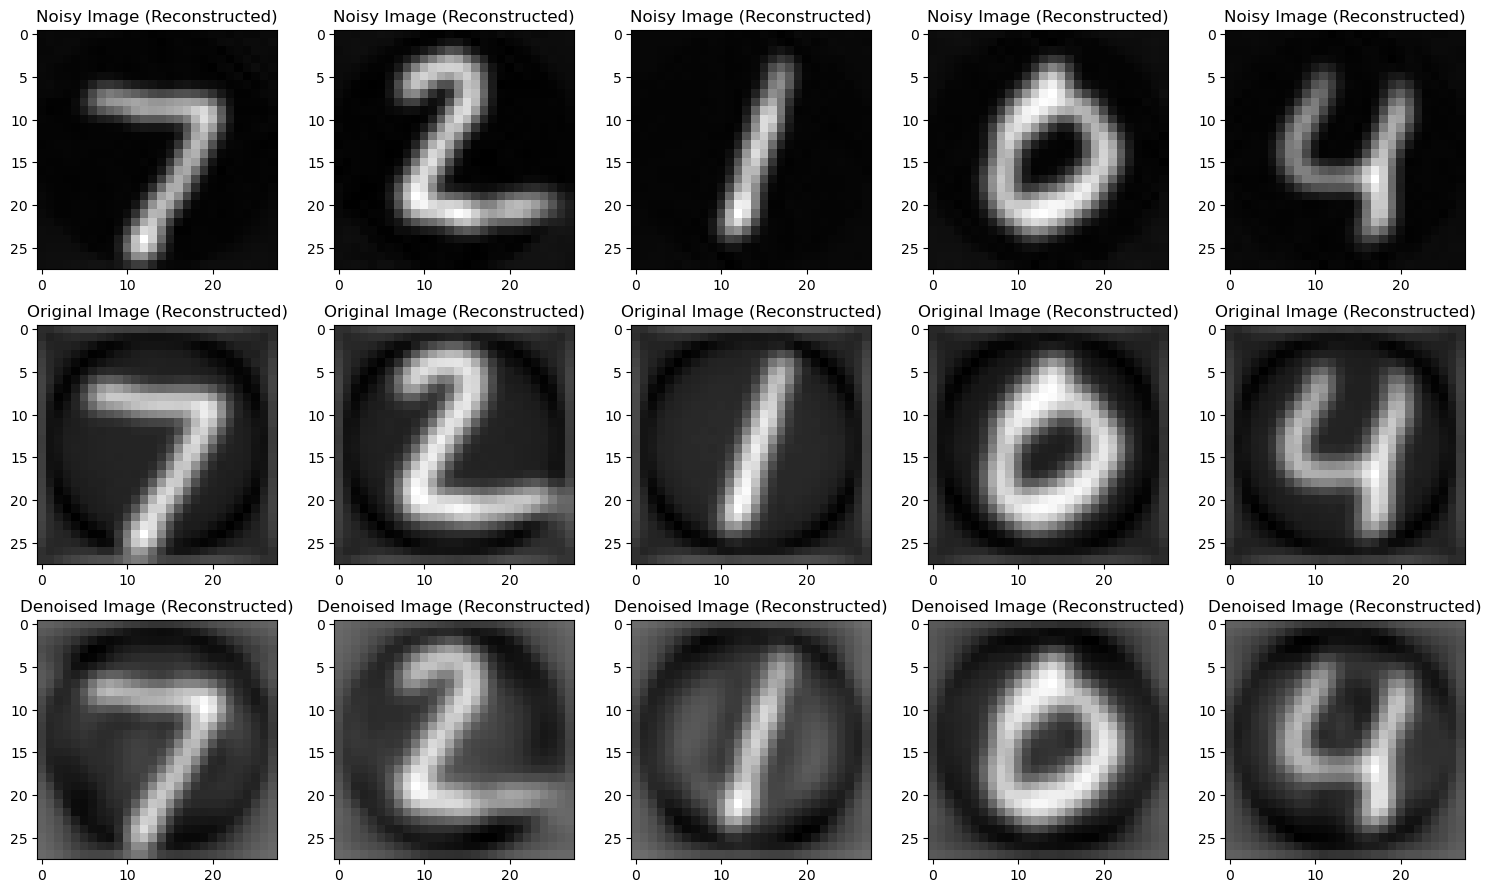

In [13]:
# Visualization
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    # 第一行：加噪后的重建图像
    axes[0, i].imshow(reconstruct_fbp(noisy_sinograms[i].cpu().numpy().squeeze()), cmap='gray')
    axes[0, i].set_title('Noisy Image (Reconstructed)')
    
    # 第二行：从干净的正弦图重建的图像
    axes[1, i].imshow(original_images[i], cmap='gray')
    axes[1, i].set_title('Original Image (Reconstructed)')
    
    # 第三行：从去噪后的正弦图重建的图像
    axes[2, i].imshow(denoised_images[i], cmap='gray')
    axes[2, i].set_title('Denoised Image (Reconstructed)')

plt.tight_layout()
plt.show()